In [1]:
from hough import imshow,bin_im2,plot_lines
from lines_generator import expand,norm
from skimage.transform import hough_line
from skimage.morphology import medial_axis
import numpy as np
import cv2
import keras
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model('models/model5.h5')

In [3]:
def genPatches(im_path,patche_size=17,reshape=True,expand_dims=False):
    
    #load image
    im_gray = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
    im_bin = bin_im2(im_gray)

    #hough transform
    dist_max = np.sqrt(im_bin.shape[0]**2+im_bin.shape[1]**2)
    im_h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/(dist_max*2)))
    im_h = im_h.astype('uint16')
    
    #first time return images
    yield im_gray.copy(),im_bin.copy(),im_h.copy()
    
    #Expand to convolution
    im_h = expand(np.array([im_h]),patche_size)[0]

    #sizes
    p = int((patche_size-1)/2)
    size = np.array(im_h.shape)-2*p
    
    #cut patches
    while(1):
        for y in range(size[0]):
            patches = list()
            for x in range(size[1]): 
                
                #cut
                patche = im_h[y:y+2*p+1,x:x+2*p+1]

                #matrix to vector
                if reshape:
                    patche = np.reshape(patche,patche_size**2)
                if expand_dims:
                    patche = np.expand_dims(patche, axis=2)
                patches.append(patche)
                
            yield np.array(patches)


In [4]:
def reconstruct(label, size):
    im = np.reshape(label,size)
    return im

In [5]:
def mask2lines(mask,size_im):
    mask = mask.copy().astype(bool)
    
    #mask to list of pixels
    size = mask.shape
    grid = np.mgrid[0:size[0],0:size[1]].astype('uint16')
    xs = grid[1][mask]
    ys = grid[0][mask]

    #pixel to angle and distance
    dist_max = np.sqrt(size_im[0]**2+size_im[1]**2)
    angles = xs*np.pi/(size[1]-1) - np.pi/2
    dists = ys*(2*dist_max)/(size[0]-1) - dist_max
    
    return dists,angles

imgs/UFPR.jpg <br>
imgs/lines.png <br>
imgs/sudoku.jpg <br>
imgs/generator/im_[1~20].png

In [6]:
patche_size=17

name = 'imgs/UFPR.jpg'
#gen = genPatches(name,reshape=True,expand_dims=False)
gen = genPatches(name,reshape=False,expand_dims=True)
im_gray,im_bin,im_h = next(gen)

size_h = np.array(im_h.shape)
size_gray = np.array(im_gray.shape)

## Predict

In [7]:
%%time
pred = model.predict_generator(gen,steps = size_h[0],verbose=1)
pred = pred[:,0]

1984/1984 [==============================] - 300s 151ms/step
CPU times: user 15min 52s, sys: 1min 39s, total: 17min 32s
Wall time: 4min 59s


## Plot

89


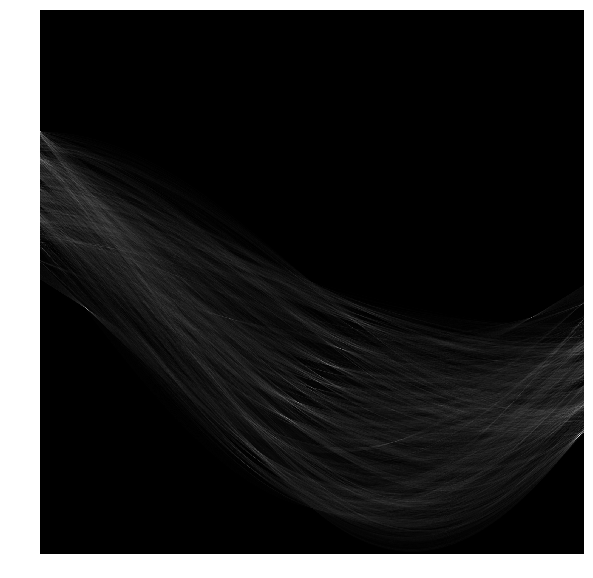

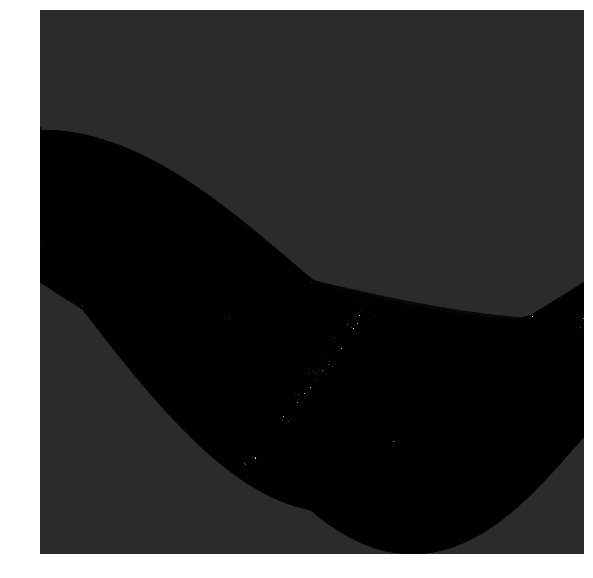

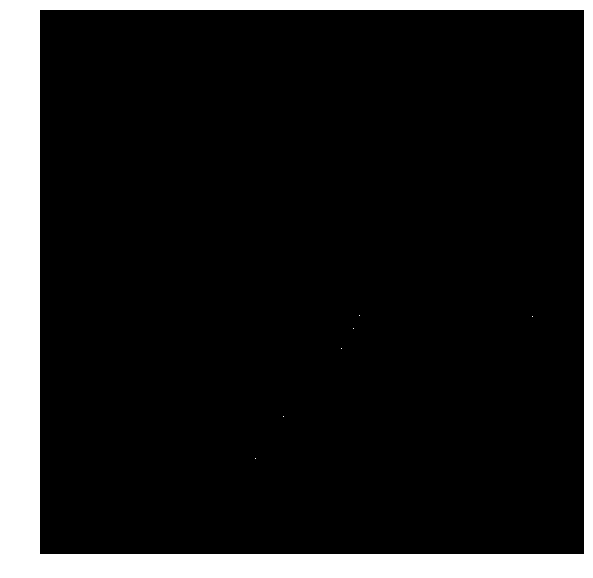

In [8]:
im = reconstruct(pred,size_h)
mask = im>0.75
print(mask.sum())
imshow(im_h)
imshow(im)
imshow(mask)

In [9]:
#cv2.imwrite('models/model5_mask.png',norm(mask))
#cv2.imwrite('models/model5_pred.png',norm(im))
#cv2.imwrite('models/model5_h.png',norm(im_h))

In [10]:
%%time
dists,angles = mask2lines(mask,size_gray)

CPU times: user 56 ms, sys: 24.1 ms, total: 80.1 ms
Wall time: 79.3 ms


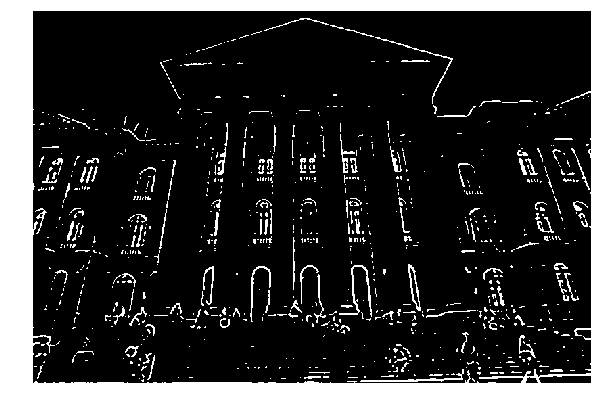

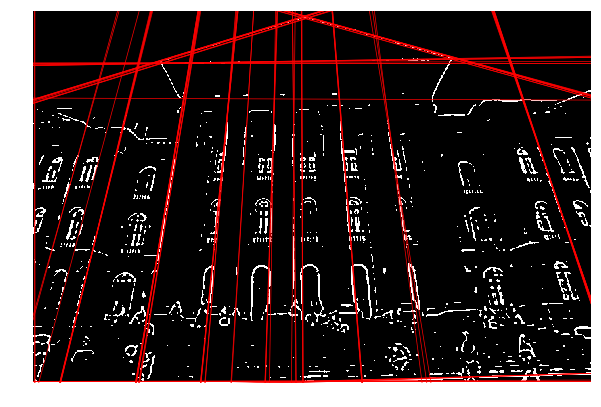

In [11]:
imshow(im_bin)
plot_lines(im_bin,dists,np.pi/2-angles) 

In [12]:
o_list = np.arange(-np.pi/2,np.pi/2,np.pi/im_h.shape[1])
d_max = np.sqrt(im_bin.shape[0]**2+im_bin.shape[1]**2)
r_list = np.arange(-d_max,d_max,d_max*2/im_h.shape[0])
r_list.shape,o_list.shape

((1984,), (1984,))

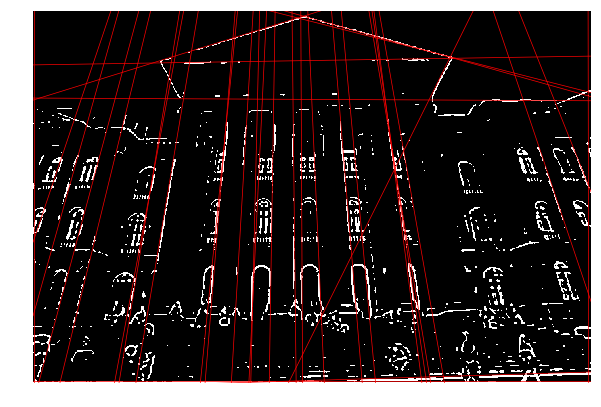

In [13]:
from skimage.transform import hough_line_peaks
_, angles, dists = hough_line_peaks(im, o_list, r_list)
plot_lines(im_bin,dists,np.pi/2-angles)